In [3]:
import sys

In [4]:
# To add your own Drive Run this cell.
##from google.colab import drive
#drive.mount('/content/drive')


In [5]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
# for example: sys.path += ['/content/drive/My Drive/cs146/hw2_code']
sys.path += ['./adult_subsample.csv']
sys.path += ['./nutil.py']
### ========== TODO : END ========== ###

In [6]:

# def install_packages(packages):
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', *packages])

# # List of packages that you need
# packages = [
#     'matplotlib'
#     # Add any other packages you want to install
# ]
from nutil import *


import sys
import subprocess

# def install_packages(packages):
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', *packages])

# install_packages(packages)



In [7]:
# Use only the provided packages!
import math
import csv

from collections import Counter


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

In [8]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [18]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        unique, counts = np.unique(y, return_counts= True)
        total = len(y)
        probability = counts/total
        self.probabilities_ = dict(zip(unique, probability))

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        classes = list(self.probabilities_.keys())
        probabilities = list(self.probabilities_.values())
        y = np.random.choice(classes, size = len(X), p = probabilities)

        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        #pass

        ### ========== TODO : END ========== ###

        return y


In [10]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [37]:


def error(clf, X, y, ntrials=100, test_size=0.15):
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.
    """
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    
    train_errors = []
    val_errors = []
    f1_scores = []
    
    for train_i, test_i in sss.split(X, y):
        X_train, X_test = X[train_i], X[test_i]
        y_train, y_test = y[train_i], y[test_i]
        if clf == DecisionTreeClassifier:
            model = clf(criterion='entropy')
        elif clf == KNeighborsClassifier:
            model = clf(n_neighbors=5)
        elif clf == LogisticRegression:
            model = clf(C=1.0, random_state=0, max_iter=1000)
        else:
            model = clf()
        
        model.fit(X_train, y_train)
        y_predicted_train = model.predict(X_train)
        train_errors.append(np.mean(y_train != y_predicted_train))
        
        y_predicted_test = model.predict(X_test)
        val_errors.append(np.mean(y_test != y_predicted_test))
        
        f1_scores.append(f1_score(y_test, y_predicted_test, average="micro"))
    
    avg_train_error = np.mean(train_errors)
    avg_val_error = np.mean(val_errors)
    avg_f1_score = np.mean(f1_scores)
    
    return avg_train_error, avg_val_error, avg_f1_score



In [12]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


In [13]:
######################################################################
# main
######################################################################

# load adult_subsample dataset with correct file path

### ========== TODO : START ========== ###
# for example data_file =  "/content/drive/My Drive/cs146/hw1/adult_subsample.csv"
data_file = "./adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


Plotting...


<Figure size 640x480 with 0 Axes>

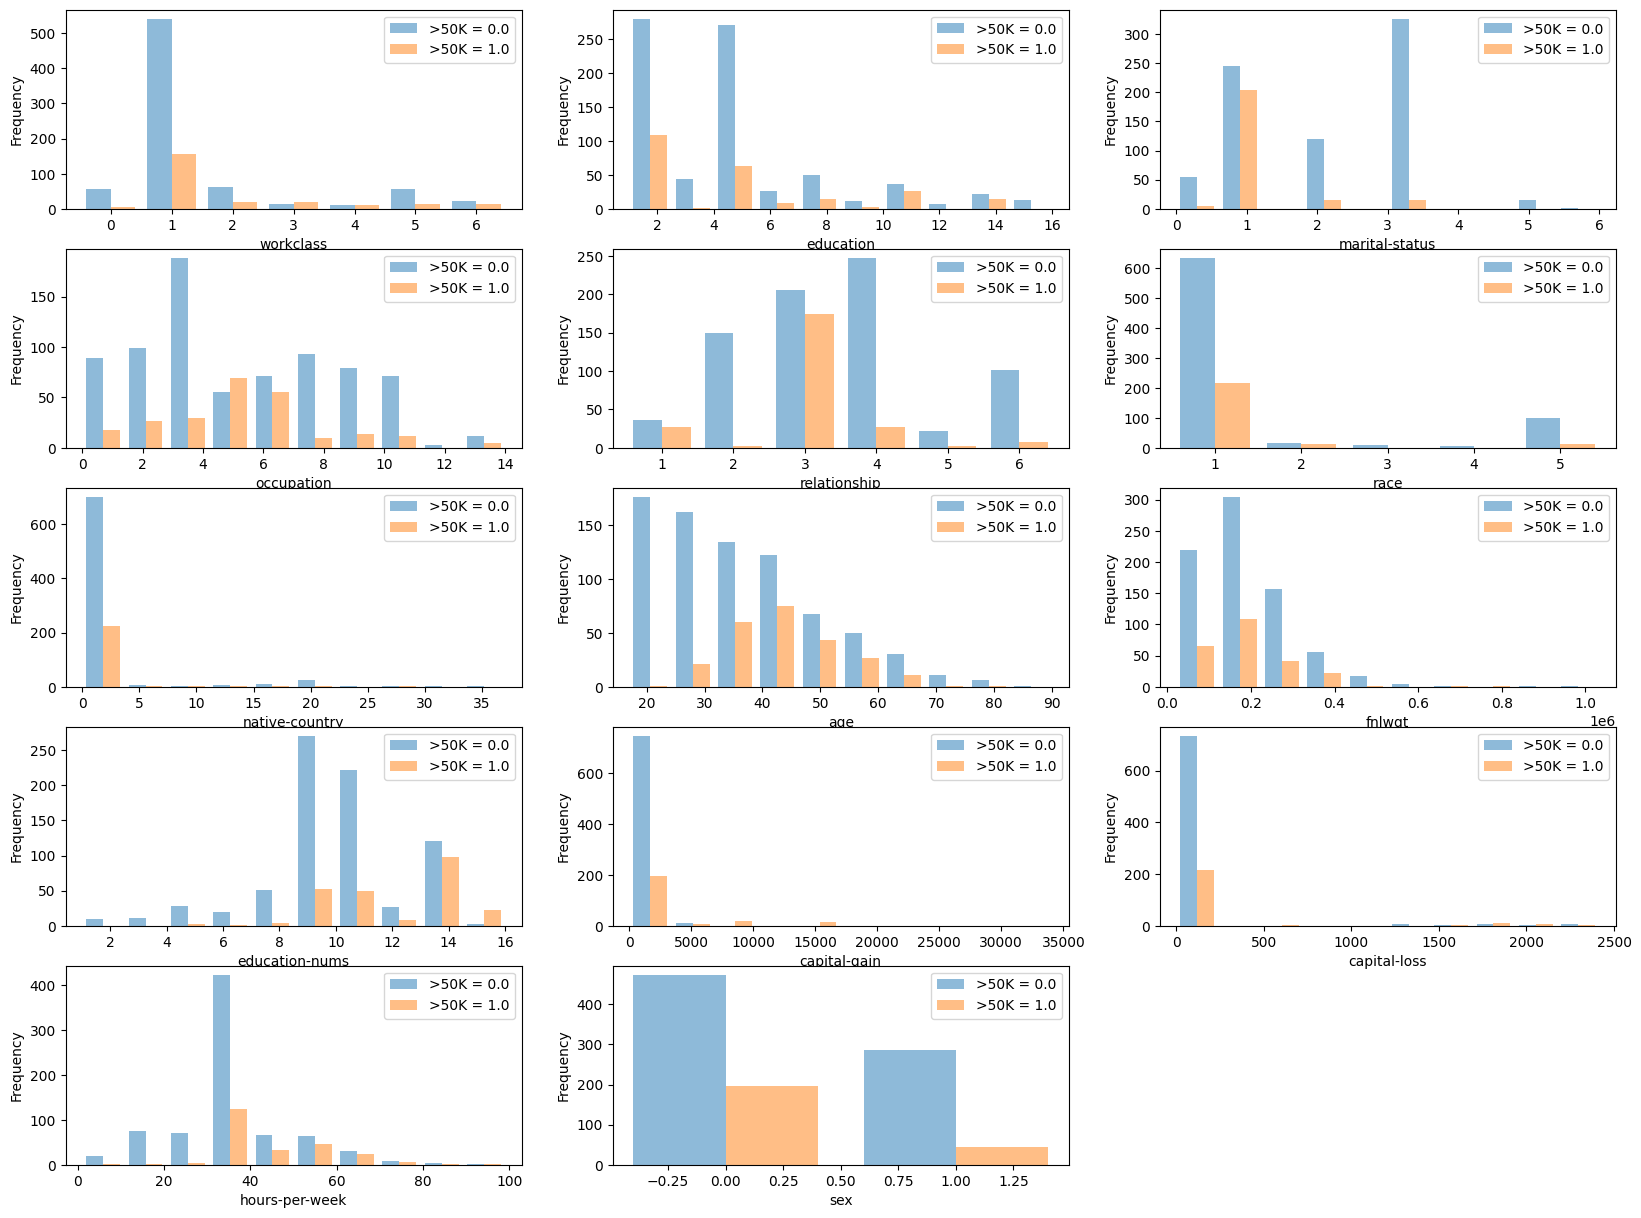

In [30]:
plt.figure()
#========================================
# part a: plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [15]:
#========================================
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.240


In [33]:
### ========== TODO : START ========== ###
# part b: evaluate training error of Random classifier
randomclassifier = RandomClassifier()
randomclassifier.fit(X, y)
y_pred = randomclassifier.predict(X)
from sklearn.metrics import accuracy_score
# 3. Calculate the training error
error = 1 - accuracy_score(y, y_pred)
print(f"Training error of Random Classifier: " + str(error))
### ========== TODO : END ========== ###

Training error of Random Classifier: 0.374


In [27]:
### ========== TODO : START ========== ###
# part c: evaluate training error of Decision Tree classifier

dt_classifier = DecisionTreeClassifier(random_state=0)
dt_classifier.fit(X, y)
y_pred = dt_classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
training_error = 1 - accuracy
print(f"Training Error of Decision Tree classifier: {training_error}")

### ========== TODO : END ========== ###

Training Error of Decision Tree classifier: 0.0


In [34]:
### ========== TODO : START ========== ###
# part d: evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors
k_values = [3, 5, 7]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X, y)
    y_pred = knn_classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    training_error = 1 - accuracy
    print(f"Training Error of k-NN classifier (k={k}):" + str(training_error))
### ========== TODO : END ========== ###

Training Error of k-NN classifier (k=3):0.15300000000000002
Training Error of k-NN classifier (k=5):0.19499999999999995
Training Error of k-NN classifier (k=7):0.21299999999999997


In [36]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
lambda_values = [0.1, 1, 10]
# Note: Make sure you initialize your classifier with the appropriate parameters: random_state=0 and max_iter=1000, using the default solver is fine.
C_values = [1.0 / lambda_ for lambda_ in lambda_values]

for C in C_values:
    logisticreg_classifier = LogisticRegression(C=C, random_state=0, max_iter=1000)
    logisticreg_classifier.fit(X, y)
    y_pred = logisticreg_classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    training_error = 1 - accuracy
    print(f"Training Error of Logistic Regression (lambda_={1.0/C}): " + str(training_error))



### ========== TODO : END ========== ###

Training Error of Logistic Regression (lambda_=0.1): 0.20799999999999996
Training Error of Logistic Regression (lambda_=1.0): 0.20799999999999996
Training Error of Logistic Regression (lambda_=10.0): 0.21999999999999997


In [39]:
from sklearn.metrics import f1_score

def evaluate_classifier(clf, name, X, y):
    avg_train_error, avg_val_error, avg_f1_score = error(clf, X, y)
    print(f"{name} - Avg Training Error: {avg_train_error}, Avg Validation Error: {avg_val_error}, Avg F1 Score: {avg_f1_score}")
print('Investigating various classifiers...')

evaluate_classifier(DecisionTreeClassifier, "Decision Tree Classifier", X, y)
evaluate_classifier(KNeighborsClassifier, "K-Nearest Neighbors Classifier (k=5)", X, y)
evaluate_classifier(LogisticRegression, "Logistic Regression (λ=1)", X, y)


Investigating various classifiers...
Decision Tree Classifier - Avg Training Error: 0.0, Avg Validation Error: 0.20133333333333334, Avg F1 Score: 0.7986666666666666
K-Nearest Neighbors Classifier (k=5) - Avg Training Error: 0.19977647058823536, Avg Validation Error: 0.2544, Avg F1 Score: 0.7455999999999999
Logistic Regression (λ=1) - Avg Training Error: 0.20741176470588232, Avg Validation Error: 0.21286666666666665, Avg F1 Score: 0.7871333333333332


Finding the best k...
The best value of k is 17 with a score of 0.7610


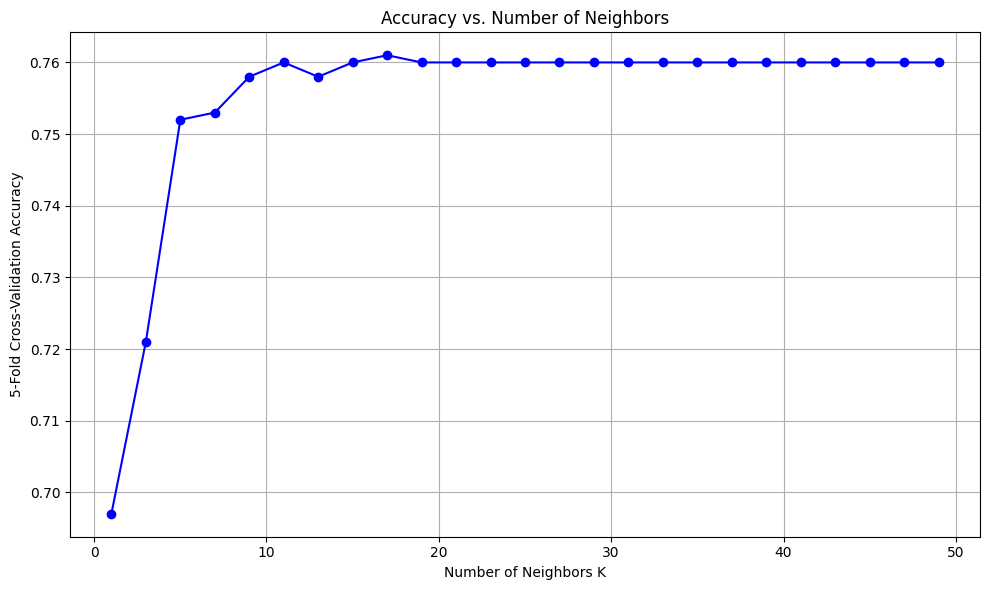

In [40]:
from sklearn.model_selection import cross_val_score
print('Finding the best k...')
cv_scores = []
k_values = list(range(1, 51, 2))
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
best_k = k_values[cv_scores.index(max(cv_scores))]
best_score = max(cv_scores)
print(f"The best value of k is {best_k} with a score of {best_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors K')
plt.ylabel('5-Fold Cross-Validation Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.tight_layout()
plt.show()


Investigating depths...


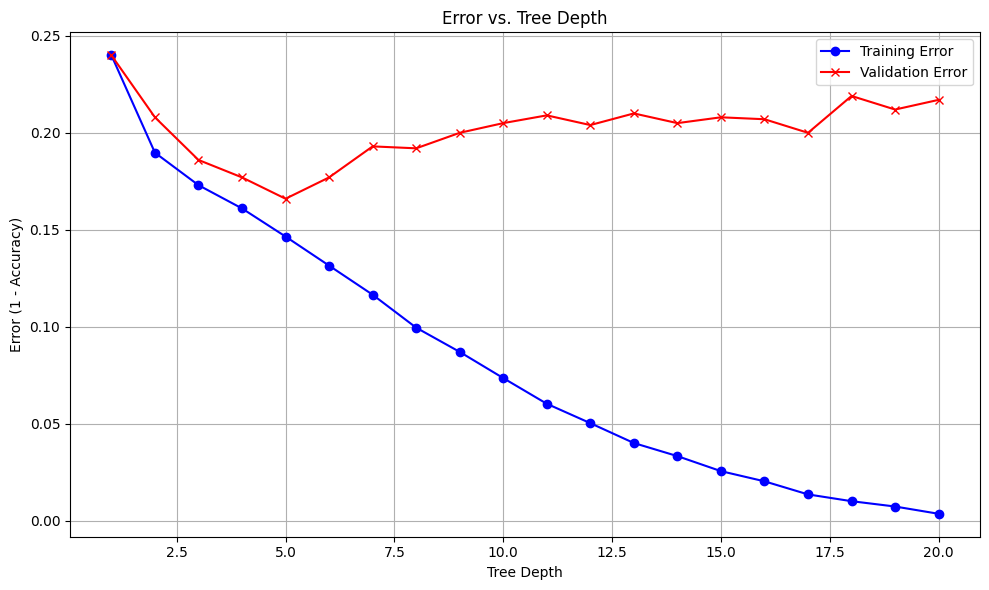

The best depth is 5 with a validation error of 0.1660


In [41]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')


depths = list(range(1, 21))
train_errors = []
val_errors = []
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    scores = cross_validate(tree, X, y, cv=5, return_train_score=True, scoring='accuracy')
    train_error = 1 - scores['train_score'].mean()
    val_error = 1 - scores['test_score'].mean()
    train_errors.append(train_error)
    val_errors.append(val_error)
plt.figure(figsize=(10, 6))
plt.plot(depths, train_errors, marker='o', linestyle='-', color='b', label='Training Error')
plt.plot(depths, val_errors, marker='x', linestyle='-', color='r', label='Validation Error')
plt.xlabel('Tree Depth')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Error vs. Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




best_depth = depths[val_errors.index(min(val_errors))]   #best depth 
print(f"The best depth is {best_depth} with a validation error of {min(val_errors):.4f}")

### ========== TODO : END ========== ###

In [ ]:
print('Done')